# NDWI - tide correlation analysis
## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, tidal_tag, model_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    flat_to_ds,
)

def correlation_loop(point_id, geom, models):
    satellite_ds = load_data(
        dc=dc,
        study_area=point_id,
        geom=geom,
        time_range=(start_date, end_date),
        resolution=resolution,
        crs=crs,
        include_s2=True,
        include_ls=True,
        filter_gqa=filter_gqa,
        dask_chunks={"x": None, "y": None},
    )

    # Load data
    satellite_ds.load()

    # Model tides
    tides_df = model_tides(
        x=satellite_ds.x.mean(),
        y=satellite_ds.y.mean(),
        time=satellite_ds.time,
        model=models,
        directory=tide_model_dir,
        crs=satellite_ds.odc.crs,
    )

    # Add to data
    satellite_ds["tide_m"] = (
        tides_df.droplevel(level=["x", "y"])
        .set_index("tide_model", append=True)
        .to_xarray()
        .tide_m.reindex_like(satellite_ds)
        .transpose("tide_model", "time")
    )

    # Calculate corrs
    _, _, corr, _ = ds_to_flat(
        satellite_ds,
        ndwi_thresh=0.0,
        min_freq=0.01,
        max_freq=0.99,
    )

    corr_mask = corr.max(dim="tide_model") >= 0.15
    corr = corr.where(corr_mask)

    out_df = (
        corr.drop("spatial_ref")
        .mean(dim="z")
        .to_dataframe(name="tide_m")
        .assign(point_id=point_id)
        .set_index("point_id", append=True)
    )

    # Add percent valid intertidal pixels analysed
    out_df["valid_perc"] = corr_mask.mean(dim="z").item()

    return out_df


## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2017"  # Informed by http://www.bom.gov.au/climate/enso/soi/?
end_date = "2019"  #  Non La Nina/El Nino period
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
# ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model_dir = "/gdata1/data/tide_models_clipped/"  # Directory containing tide model files

# Models to run
models = [
    "FES2014",
    "TPXO9-atlas-v5",
    "EOT20",
    "HAMTIDE11",
    "GOT4.10",
    "FES2012",
    "TPXO8-atlas-v1",
]

### Load correlation points

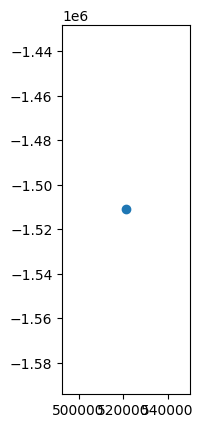

In [5]:
# Load points
points_gdf = gpd.read_file("data/raw/tide_correlation_points_input.geojson").to_crs("EPSG:3577")

# Select subset
points_gdf, name = points_gdf.iloc[[0]], "test"
# points_gdf, name = points_gdf.iloc[0:500], "robbi_part1"
# points_gdf, name = points_gdf.iloc[500:1000], "robbi_part2"
# points_gdf, name = points_gdf.iloc[1000:1500], "claire_part1"
# points_gdf, name = points_gdf.iloc[1500:2000], "claire_part2"
# points_gdf, name = points_gdf.iloc[2000:2500], "ness_part1"
# points_gdf, name = points_gdf.iloc[2500:3000], "ness_part2"
points_gdf.plot()

# Apply buffer
points_gdf["geometry"] = points_gdf.geometry.buffer(2500)


## Run correlation analysis

In [9]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

out_list = []

for i, row in tqdm(points_gdf.iterrows(), 
                   total=points_gdf.shape[0]):
    
    try:
    
        point_id = row.id
        print(f"Processing ID {point_id}")
        geom = Geometry(row.geometry, crs="EPSG:3577")       

        output_df = correlation_loop(point_id, geom, models)
        output_df["x"] = row.geometry.centroid.x
        output_df["y"] = row.geometry.centroid.y

        out_list.append(output_df)

        client.restart()
    
    except:
        print(f"{point_id} failed; skipping")

  0%|          | 0/1 [00:00<?, ?it/s]

Processing ID 0
0 failed; skipping


### Combine and process data

In [ ]:
# Combine outputs into single dataframe
combined_df = (
    pd.concat(out_list)
    .set_index(["x", "y", "valid_perc"], append=True)
    .unstack("tide_model")["tide_m"]
    .assign(source="ndwi correlation", statistic="correlation")
    .reset_index(["x", "y", "valid_perc"])
    .reindex(["x", "y", "valid_perc", "source", "statistic"] + models, axis=1)
)

# Add additional columns
combined_df["min"] = combined_df.loc[:, models].min(axis=1)
combined_df["max"] = combined_df.loc[:, models].max(axis=1)
combined_df["diff"] = combined_df["max"] - combined_df["min"]
combined_df["ave"] = combined_df.loc[:, models].mean(axis=1)
combined_df["std"] = combined_df.loc[:, models].std(axis=1)

# Calculate ranks and best/worst models
combined_df = pd.concat(
    [combined_df, combined_df.loc[:, models].rank(axis=1).add_prefix("rank_")], axis=1
)
combined_df["top_model"] = combined_df.filter(regex='^rank').idxmax(axis=1).str[5:]
combined_df["worst_model"] = combined_df.filter(regex='^rank').idxmin(axis=1).str[5:]
combined_df

### Export

In [ ]:
gpd.GeoDataFrame(
    data=combined_df,
    geometry=gpd.points_from_xy(combined_df.x, combined_df.y, crs="EPSG:3577"),
).to_crs("EPSG:4326").to_file(f"data/raw/tide_correlation_points_{name}.geojson")

### Combine

In [ ]:
tide_correlation_points = pd.concat(
    [
        gpd.read_file("data/raw/tide_correlation_points_robbi_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_robbi_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part2.geojson")
    ]
).dropna(subset="FES2014")

# Convert x/y to lat/lon
tide_correlation_points["x"] = tide_correlation_points.geometry.x
tide_correlation_points["y"] = tide_correlation_points.geometry.y

# Export
tide_correlation_points.to_file(f"data/raw/tide_correlations_2017-2019.geojson")

#### Combine with altimetry

In [ ]:
# gpd.read_file("data/raw/xtrack_rms_2017-2019.geojson")